# "Computing Trajectories of the Lorenz system using Adaptive Runge-Kutta Method"
 
> "Notebook contains the project for the PHY 312 Mid-term Assesment"
- toc: true
- badges: true
- comments: true
- categories: [python]
- author: Sandesh Katakam & K Roshan Raj
- image: images/lorenz.png

## Installing Dependencies 

In [2]:
# Run the Code Block to install Dependencies
import numpy as np
import matplotlib.pyplot as plt
import math, sys 
from ipywidgets import interact, interactive
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

## Lorenz System

* The Lorenz system is a system of ordinary differential equations first studied by mathematician and meteorologist Edward Lorenz. 

* It is notable for having chaotic solutions for certain parameter values and initial conditions. 

* In particular, the Lorenz attractor is a set of chaotic solutions of the Lorenz system. 

* In popular media the "butterfly effect" stems from the real-world implications of the Lorenz attractor

* It states that in a chaotic physical system, in the absence of perfect knowledge of the initial conditions (even the minuscule disturbance of the air due to a butterfly flapping its wings), our ability to predict its future course will always fail.

![]("../lorenzattractor.png")

## Lorenz System of Equations 

The Lorenz Equations relate the properties of two-dimensional fluid layer uniformly warmed from below and cooled from above.  
  



$$\frac{dx}{dt} = \sigma (y-x)$$
$$\frac{dy}{dt} = x(\rho - z) - y$$
$$\frac{dz}{dt} = xy - \beta z$$

The Equations below describe the rate of change of three quantities with respect to time:  
  
* 𝒙  is proportional to the rate of convection
* 𝒚 is proportional to the horizontal temperature variation
* 𝔃 is proportional to the vertical temperature.

The constants  σ, ρ, and β  are system parameters proportional to:
  
* σ  : Prandtl number
* ρ : Rayleigh number
* β  : Certain physical dimension of layer itself

In [28]:
# Define the lorzrk function used by the Runge-Kutta routines
def lorzrk(s,t,param):
    """Returns right-hand side of Lorenz model ODEs
       Inputs
         s      State vector [x y z]
         t      Time (not used)
         param  Parameters [r sigma b]
       Output
         deriv  Derivatives [dx/dt dy/dt dz/dt]
    """
    
    #* For clarity, unravel input vectors
    x, y, z = s[0], s[1], s[2]
    r = param[0]
    sigma = param[1]
    b = param[2]

    #* Return the derivatives [dx/dt dy/dt dz/dt]
    deriv = np.empty(3)
    deriv[0] = sigma*(y-x)
    deriv[1] = r*x - y - x*z
    deriv[2] = x*y - b*z
    return deriv


## Implementation of Adaptive Runge-Kutta(4th Order RK Method)

### Runge-Kutta Method(4th Order RK Method):

* The Most Commonly used Runge-Kutta method to find the solution of a differential equation is the RK4 Method(i.e. Fourth order Runge-Kutta Method).  
* The Runge-Kutta method provides the approximate value of y for a given point x.   
* Only the first order ODEs can be solved using the Runge Kutta RK4 Method.
  
$$ y_{1} = y_{0} + \frac{1}{6} \cdot (k_{1} + 2k_{2} + k{4})$$  
Here,  
  
$k_{1} = hf(x_{0}, y_{0})$  
$k_{2} = hf[x_{0} + \frac{1}{2}h, y_{0} + \frac{1}{2} k_{1}]$  
$k_{3} = hf[x_{0} + \frac{1}{2} h, y_{0} + \frac{1}{2} k_{2}]$  
$k_{4} = hf(x_{0} + h, y_{0} + k_{3})$  


In [27]:
# Code Implementation of Runge-Kutta Integrator for 4th order Differential Equations
def rk4(x,t,tau,derivsRK,param):
    """Runge-Kutta integrator (4th order)
       Input arguments -
        x = current value of dependent variable
        t = independent variable (usually time)
        tau = step size (usually timestep)
        derivsRK = right hand side of the ODE; derivsRK is the
                  name of the function which returns dx/dt
                  Calling format derivsRK (x,t,param).
        param = extra parameters passed to derivsRK
       Output arguments -
        xout = new value of x after a step of size tau
    """
    
    half_tau = 0.5*tau
    F1 = derivsRK(x,t,param)  
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp,t_half,param)  
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2+F3))
    return xout

### Adaptive Runge-Kutta Method Implementation

* Adaptive Runge-Kutta Method is an variation of Runge-Kutta where there is no requirement for the step-size. Instead we adapt the step size in order to reach an accuracy goal, as measured by an error estimate formed from computing multiple Approximations.
* In simple words, it means the implementation will take care of the step size and we just need to specify our desired accuracy by giving the error tolerance as input

In [26]:
# Code Implementation of Adaptive Runge-Kutta technique
def rka(x,t,tau,err,derivsRK,param):
    """Adaptive Runge-Kutta routine
       Inputs
        x          Current value of the dependent variable
        t          Independent variable (usually time)
        tau        Step size (usually time step)
        err        Desired fractional local truncation error
        derivsRK   Right hand side of the ODE; derivsRK is the
                   name of the function which returns dx/dt
                   Calling format derivsRK (x,t,param).
        param      Extra parameters passed to derivsRK
       Outputs
        xSmall     New value of the dependent variable
        t          New value of the independent variable
        tau        Suggested step size for next call to rka
    """
    
    #* Set initial variables
    tSave, xSave = t, x        # Save initial values
    safe1, safe2 = 0.9, 4.0    # Safety factors
    eps = 1.e-15

    #* Loop over maximum number of attempts to satisfy error bound
    xTemp = np.empty(len(x))
    xSmall = np.empty(len(x)); xBig = np.empty(len(x))
    maxTry = 100
    for iTry in range(maxTry):

        #* Take the two small time steps
        half_tau = 0.5 * tau
        xTemp = rk4(xSave,tSave,half_tau,derivsRK,param)
        t = tSave + half_tau
        xSmall = rk4(xTemp,t,half_tau,derivsRK,param)
  
        #* Take the single big time step
        t = tSave + tau
        xBig = rk4(xSave,tSave,tau,derivsRK,param)
  
        #* Compute the estimated truncation error
        scale = err * (abs(xSmall) + abs(xBig))/2.
        xDiff = xSmall - xBig
        errorRatio = np.max( np.absolute(xDiff) / (scale + eps) )
  
        #* Estimate new tau value (including safety factors)
        tau_old = tau
        tau = safe1*tau_old*errorRatio**(-0.20)
        tau = max(tau, tau_old/safe2)
        tau = min(tau, safe2*tau_old)
  
        #* If error is acceptable, return computed values
        if errorRatio < 1 :
            return np.array([xSmall, t, tau]) 

    #* Issue error message if error bound never satisfied
    print('ERROR: Adaptive Runge-Kutta routine failed')
    return np.array([xSmall, t, tau])



C:\Users\sande\AppData\Local\Temp\ipykernel_30316\743962485.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


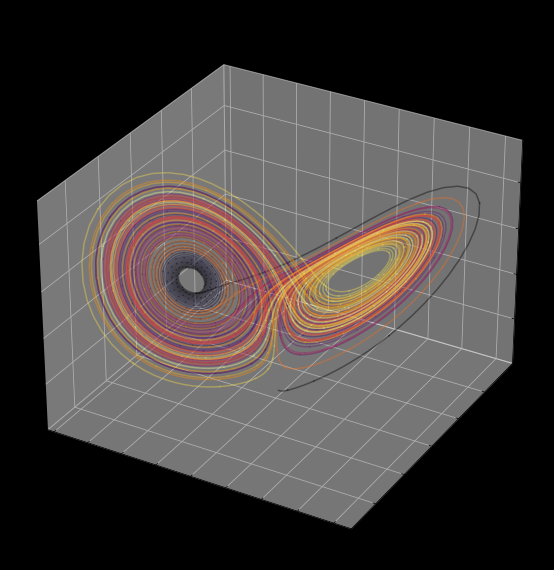

In [61]:
def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = -sigma*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    return up, vp, wp

# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                 dense_output=True)

## Visualization of Trajectories of Lorenz System 

We will Plot the Trajectories for the Lorenz System of Equations with the Given parameters and Initial Conditions  
You can tweak the initial Conditions and Visualize the results
### Lorenz paramters and initial conditions:
#### Parameters:
* $\sigma = 10 $
* $\beta = 2.667 $
* $\rho = 28$

#### Initial Conditions:
* $x = 0$
* $y = 1$
* $z = 1.05$


In [123]:
def visualize_trajectories(tmax, n, set_axis = "on", change_color = True, cmap = plt.cm.inferno):
    """
    Arguments:
    ---------
    tmax: Maximum Time step till which the trajectory should be plotted
    n : stepper
    set_axis : 'on' plots with axis 'off' plots without axis
    change_color : If set to "True" will change the color scheme of the trajectory after specified number of steps
    cmap : Set the color map for the trajectory, Default: plt.cm.inferno
    
    Returns the Visualization of Trajectories from the solutions of Lorenz system
    """
    # Interpolate solution onto the time grid, t.
    t = np.linspace(0,tmax, n)
    x,y,z = soln.sol(t)
    # Specifying the Image width of the Trajectory plots
    WIDTH, HEIGHT, DPI = 750, 750, 100
    # Plot the Lorenz attractor using a Matplotlib 3D projection.
    fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
    
    ax = fig.gca(projection='3d')
    ax.set_facecolor('k')
    if set_axis == "off":
        ax.set_axis_off()
    elif set_axis == "on":
        pass
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if change_color == True:
        s = 10 # For every 10 time steps the color changes in the range of color map specified
        cmap = cmap
        for i in range(0,n-s,s):
            ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)
        plt.title(f"Trajectories of Lorenz System for Parameters sigma = {sigma}, beta = {beta}, rho = {rho}")
        plt.savefig('lorenz.png', dpi=DPI)
        plt.show()
    elif change_color == False:
        
        s = 10
        for i in range(0,n-s,s):
            ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color = 'm') # change the color parameter here manually
        plt.title(f"Trajectories of Lorenz System for Parameters sigma = {sigma}, beta = {beta}, rho = {rho}")
        plt.savefig('lorenz.png', dpi=DPI)
        plt.show()

In [141]:
#collapse-hide
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

C:\Users\sande\AppData\Local\Temp\ipykernel_30316\124449006.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


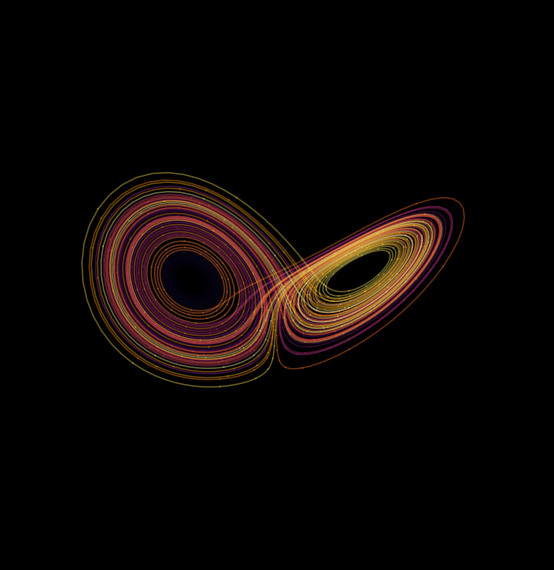

In [139]:
tmax, n = 100, 10000
visualize_trajectories(tmax, n, set_axis = "off", change_color = True)

C:\Users\sande\AppData\Local\Temp\ipykernel_30316\124449006.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


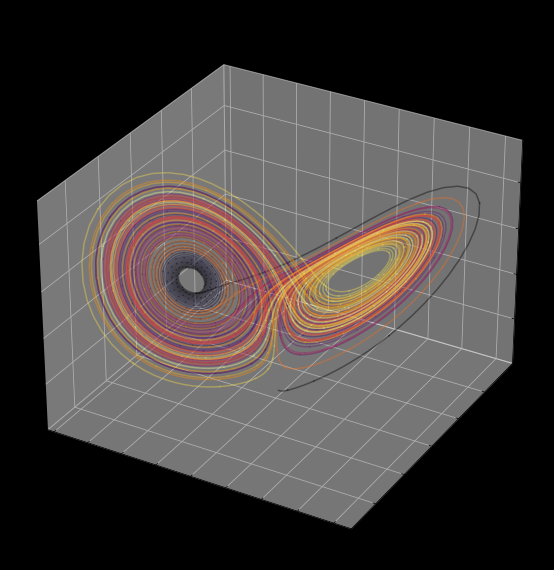

In [137]:
visualize_trajectories(tmax, n, set_axis = "on", change_color = True)

C:\Users\sande\AppData\Local\Temp\ipykernel_30316\124449006.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


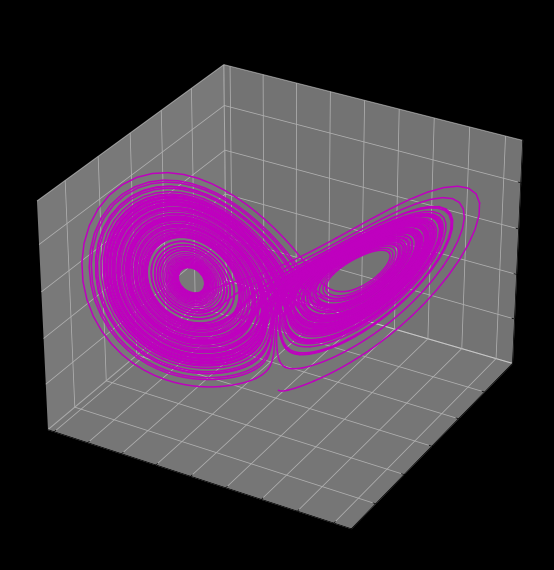

In [138]:
visualize_trajectories(tmax, n, set_axis = "on", change_color = False)

## References: 
* [Adaptive Runge-Kutta Method](https://fncbook.github.io/fnc/ivp/adaptive.html)
* [Runge-Kutta Method(RK4 Method)](https://byjus.com/maths/runge-kutta-rk4-method/)
* [matplotlib documentation](https://matplotlib.org/2.0.2/api/_as_gen/matplotlib.axes.Axes.plot.html)